In [1]:
%matplotlib inline

import os
import shutil
import random

import numpy as np

from PIL import Image
from pathlib import Path

from matplotlib import pyplot as plt

import torch
import torchvision
torch.manual_seed(0)
from torchvision.transforms import transforms
print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.10.2+cpu


In [2]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [3]:
def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

In [4]:
predict_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
predict_dirs = {
    'normal': 'D:\\Project\\COVID Detection form Chest X-ray Images\\predict\\normal',
    'viral': 'D:\\Project\\COVID Detection form Chest X-ray Images\\predict\\viral',
    'covid': 'D:\\Project\\COVID Detection form Chest X-ray Images\\predict\\covid'
}

predict_dataset = ChestXRayDataset(predict_dirs, predict_transform)
predict_test = torch.utils.data.DataLoader(predict_dataset)

Found 8 normal examples
Found 10 viral examples
Found 12 covid examples


In [7]:
model = torchvision.models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(in_features=2048, out_features=3)
checkpoint = torch.load(Path('D:\\Project\\COVID Detection form Chest X-ray Images\\resnet18-model.h5'))
model.load_state_dict(checkpoint)

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

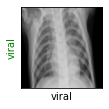

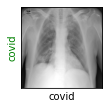

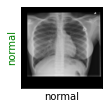

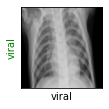

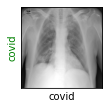

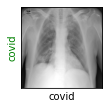

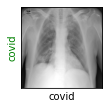

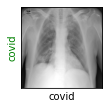

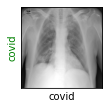

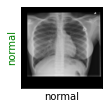

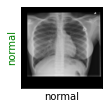

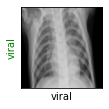

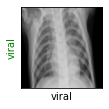

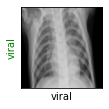

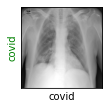

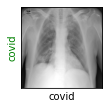

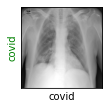

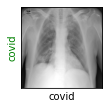

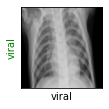

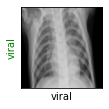

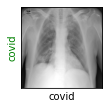

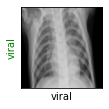

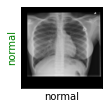

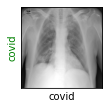

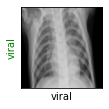

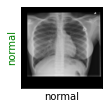

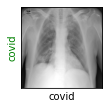

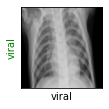

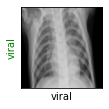

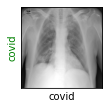

In [8]:
class_names = predict_dataset.class_names
for i in range(0,len(predict_test)):
    image, label = next(iter(predict_test))
    output = model(image)
    _, pred = torch.max(output, 1)
    show_images(image, label, pred)